# PASCAL Person Part - Light-Weight Refinenet

## 6 semantic classes + background

### Light-Weight RefineNet based on ResNet-50/101/152

In [1]:
import six
import sys
sys.path.append('../../')

from models.resnet import rf_lw50, rf_lw101, rf_lw152

In [2]:
from utils.helpers import prepare_img

In [3]:
%matplotlib inline

import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from PIL import Image

In [4]:
cmap = np.load('../../utils/cmap.npy')
has_cuda = torch.cuda.is_available()
img_dir = '../imgs/Person/'
imgs = glob.glob('{}*.jpg'.format(img_dir))
n_classes = 7

In [5]:
# Initialise models
model_inits = { 
    'rf_lw50_person'   : rf_lw50, # key / constructor
    'rf_lw101_person'  : rf_lw101,
    'rf_lw152_person'  : rf_lw152,
    }

models = dict()
for key,fun in six.iteritems(model_inits):
    net = fun(n_classes, pretrained=True).eval()
    if has_cuda:
        net = net.cuda()
    models[key] = net

/home/vladimir/Documents/venvs/darts/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


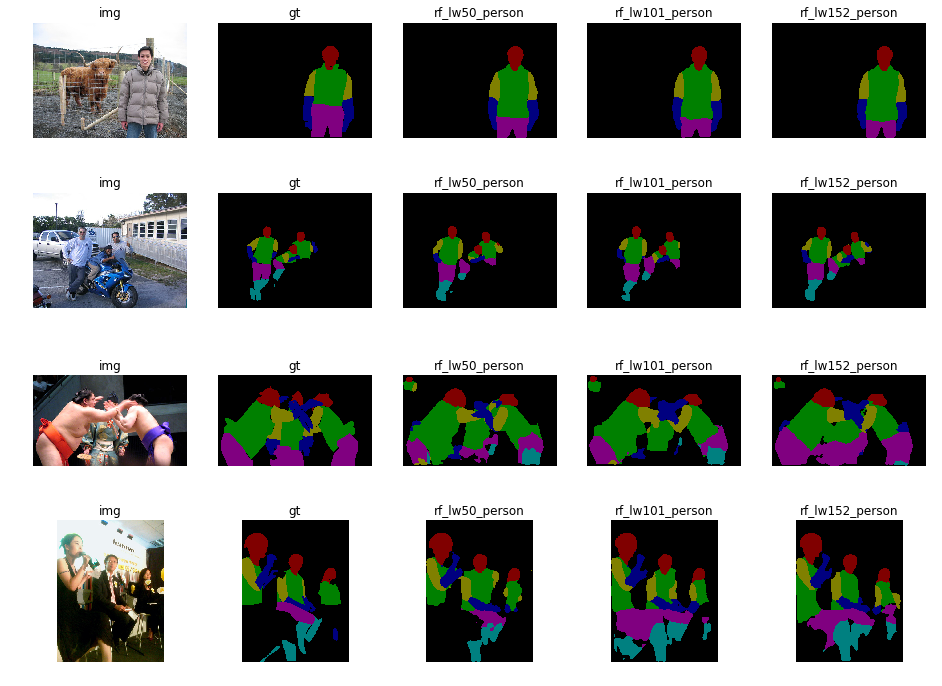

In [6]:
# Figure 3 from the supplementary
n_cols = len(models) + 2 # 1 - for image, 1 - for GT
n_rows = len(imgs)

plt.figure(figsize=(16, 12))
idx = 1

with torch.no_grad():
    for img_path in imgs:
        img = np.array(Image.open(img_path))
        msk = cmap[np.array(Image.open(img_path.replace('jpg', 'png')))]
        orig_size = img.shape[:2][::-1]
        
        img_inp = torch.tensor(prepare_img(img).transpose(2, 0, 1)[None]).float()
        if has_cuda:
            img_inp = img_inp.cuda()
        
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(img)
        plt.title('img')
        plt.axis('off')
        idx += 1
        
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(msk)
        plt.title('gt')
        plt.axis('off')
        idx += 1
        
        for mname, mnet in six.iteritems(models):
            segm = mnet(img_inp)[0].data.cpu().numpy().transpose(1, 2, 0)
            segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC)
            segm = cmap[segm.argmax(axis=2).astype(np.uint8)]
            
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(segm)
            plt.title(mname)
            plt.axis('off')
            idx += 1